### Titanic Machine Learning
The objective is to predict which passengers survive, and which don't.
We know that passenger could get on in Southampton (England), Cherbourg (France), and in Queenstown (Ireland).
We expect that socioeconomic strata plays a role in who survives. This is probably indicated by the class of cabin the passengers were in.

### Exploratory Data Analysis

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [169]:
# Load titanic data
train_data= pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
pd.set_option('display.max_rows', 1000)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


So, the `Cabin` attribute has a lot of null values. What other attributes have lots of null values? Run `test_data.info()`

In [84]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We see that the `Age` attribute is also missing many values.

In [85]:
train_data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Looking at the correlation matrix, `Survived` seems to be correlated strongly with `Pclass` (the lower the class, i.e. higher number, the less chances of survival), and `Fare` (the more you paid, the more likely you are to survive.)

Let's look at the distribution of `Age`, `SibSp`, `Parch` and `Fare`

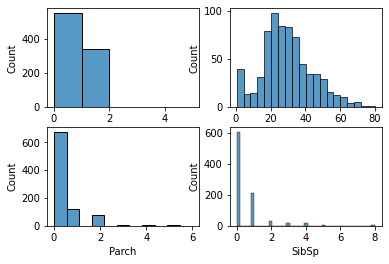

In [86]:
plt.subplot(221)
sns.histplot(train_data, x="Survived", bins=[0,1,2,3,4,5])

plt.subplot(222)
sns.histplot(train_data, x="Age")

plt.subplot(223)
sns.histplot(train_data, x="Parch")

plt.subplot(224)
sns.histplot(train_data, x="SibSp")

plt.show()

So, this suggests that more died than they did survive. There were a lot of people between 20 and 30, and a few infants. Most people had no children or parents with them, but about 100 had either one or two children. Similary for siblings or spouses, most people had none, but about 200 had one. I would guess that this is mainly spouses.

## Feature Engineering

The `Age` attribute has a lot of null values. Let's start by finding the median age of passengers by `Sex` and `Pclass`. These lines are taken from [here](https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial)

In [170]:
age_by_pclass_sex = train_data.groupby(['Sex', 'Pclass']).median()['Age']
age_by_pclass_sex = age_by_pclass_sex.reset_index()
age_by_pclass_sex

,Sex,Pclass,Age
0,female,1,35.0
1,female,2,28.0
2,female,3,21.5
3,male,1,40.0
4,male,2,30.0
5,male,3,25.0


In [171]:
def impute_age(df, age_by_pclass_sex):
    df_to_return = df.copy()
    for sex in ['male', 'female']:
        for c in range(1,4):
            df_to_return.loc[ (df_to_return.Age.isnull()) & 
                   (df_to_return.Sex == sex) & 
                   (df_to_return.Pclass == c), "Age" ] = age_by_pclass_sex.loc[ (age_by_pclass_sex.Sex == sex) &
                                                                        (age_by_pclass_sex.Pclass == c), "Age"]
    
    # df_to_return["Age"] = train_data.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
    return df_to_return
train_data = impute_age(train_data, age_by_pclass_sex)
train_data[["Sex", "Pclass", "Age"]].iloc[0:25]

,Sex,Pclass,Age
0,male,3,22.0
1,female,1,38.0
2,female,3,26.0
3,female,1,35.0
4,male,3,35.0
5,male,3,25.0
6,male,1,54.0
7,male,3,2.0
8,female,3,27.0
9,female,2,14.0


Let's get the titles of people from their name. The names are all in order of `last_name, title. first_name last_name`. So, let's split on the `,` and the `.`

In [ ]:
# # Impute the Age attribute
# from sklearn.impute import SimpleImputer

# def impute_age(df):
#     imputer = SimpleImputer(strategy="median")
#     age_data = df[['Age']]
#     imputer.fit(age_data)
#     age_data_transformed = imputer.transform(age_data)
#     age_data_transformed = pd.DataFrame(age_data_transformed, columns=age_data.columns)
#     df[["Age"]] = age_data_transformed
#     return df

# train_data = impute_age(train_data)
# test_data = impute_age(test_data)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch", "Age"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('random_forest_submission.csv', index=False)
print("Your submission was successfully saved!")

This submission scored 77.2%; excluding `Age` scores 77.5%

In [ ]:
from sklearn.linear_model import SGDClassifier

y = train_data["Survived"]
features = ["Pclass", "Sex", "SibSp", "Parch", "Age"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X, y)
predictions = sgd_clf.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('sgd_classifier_submission.csv', index=False)
print("Your submission was successfully saved!")

This scores only 42.1%.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y = train_data["Survived"]
features = ["Pclass", "Sex", "SibSp", "Parch", "Age"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

knn_clf = KNeighborsClassifier()
knn_clf.fit(X, y)
predictions = knn_clf.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('knn_classifier_submission.csv', index=False)
print("Your submission was successfully saved!")

Scores 66.3%.

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors = 6, weights = 'distance')
knn_clf.fit(X, y)
predictions = knn_clf.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('knn_classifier_six_neighbours_submission.csv', index=False)
print("Your submission was successfully saved!")

Same score.

In [ ]:
# Try including Embarkment

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('random_forest_submission.csv', index=False)
print("Your submission was successfully saved!")

Still, only 77%; Not as good as the first random forest